# Run workload

Assumming `oc login` already run. 

Settings:

- Workload parameters: `prometheus-sizing/env.sh`
- Prometheus metrics to collect when workload is complete: `prometheus-sizing/metrics.yaml`

In [1]:
! cd ../../workloads/prometheus-sizing && rm -rf collected-metrics/* && source ../../notebooks/e2e-benchmarking/prometheus-sizing/env.sh && ./prometheus-sizing-churning.sh

Wed Aug 24 17:43:38 UTC 2022 Pods to deploy across worker nodes: 50
Wed Aug 24 17:43:38 UTC 2022 We'll create 8 namespaces with 6 pods each
Wed Aug 24 17:43:38 UTC 2022 Running kube-burner using config prometheus-sizing-churning.yml and metrics /Users/jrodrig/git/cloud-bulldozer/e2e-benchmarking/notebooks/e2e-benchmarking/prometheus-sizing/metrics.yaml
INFO[2022-08-24 19:43:40] 🔥 Starting kube-burner (0.16.1@ab32f2da956094baf794ae09f75ccfca48ff018b) with UUID 2A510954-7509-43D3-A083-603EBED3C29B 
INFO[2022-08-24 19:43:40] 👽 Initializing prometheus client             
INFO[2022-08-24 19:43:40] 📈 Creating measurement factory               
INFO[2022-08-24 19:43:40] Preparing create job: prometheus-sizing-churning 
INFO[2022-08-24 19:43:40] Job prometheus-sizing-churning: 8 iterations with 6 Pod replicas 
INFO[2022-08-24 19:43:40] Preparing delete job: prometheus-sizing-churning-delete-1 
INFO[2022-08-24 19:43:40] Job prometheus-sizing-churning-delete-1: Delete Namespace with selector nam

# Process results

In [2]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import os
from IPython.display import display, HTML

In [3]:
! for f in $(find '../../workloads/prometheus-sizing/collected-metrics' -type f); do bf=$(basename "${f}"); cp -v "${f}" "$(dirname $f)/${bf%%-*}.json"; done

../../workloads/prometheus-sizing/collected-metrics/prometheusNetworkRateFiveMin-2A510954-7509-43D3-A083-603EBED3C29B.json -> ../../workloads/prometheus-sizing/collected-metrics/prometheusNetworkRateFiveMin.json
../../workloads/prometheus-sizing/collected-metrics/prometheusMemory-2A510954-7509-43D3-A083-603EBED3C29B.json -> ../../workloads/prometheus-sizing/collected-metrics/prometheusMemory.json
../../workloads/prometheus-sizing/collected-metrics/prometheusTsdbHeadChunks-2A510954-7509-43D3-A083-603EBED3C29B.json -> ../../workloads/prometheus-sizing/collected-metrics/prometheusTsdbHeadChunks.json
../../workloads/prometheus-sizing/collected-metrics/prometheusTsdbStorageBlockBytes-2A510954-7509-43D3-A083-603EBED3C29B.json -> ../../workloads/prometheus-sizing/collected-metrics/prometheusTsdbStorageBlockBytes.json


In [4]:
root_metrics_path = '../../workloads/prometheus-sizing/collected-metrics/'

def print_metric_name(metric_name):
    print('-'*20 + f"\n{metric_name}\n" + '-'*20)
def get_metric(metric_name):
    print_metric_name(metric_name)
    
    data_path = os.path.join(root_metrics_path, f"{metric_name}.json")
    df = pd.read_json(data_path, orient='records')
    
    df["timestamp"] = pd.to_datetime(df["timestamp"], infer_datetime_format=True)
    df.set_index('timestamp', inplace=True)

    df['value'] = df['value'].astype('float64')

    label_keys = ['namespace', 'pod']
    def expand_labels(row):
        labels = row['labels']
        return { k : labels[k] for k in label_keys}
    df[label_keys] = df.apply(expand_labels, axis="columns", result_type='expand')
    df.drop(columns=['labels'], inplace=True)


    constant_columns = ['metricName', 'query', 'namespace']
    for col in constant_columns:
        print(df[col].unique())
    df.drop(columns=constant_columns, inplace=True)

    for col in ['pod']:
        print(f"column {col} values: {df[col].unique()}")

    return df

def metric_summary(metric_name, df):
    display(df['value'].describe())
    pod_names = list(df['pod'].unique())
    for pod_name in pod_names:
        pod_df = df[df['pod'] == pod_name]
        pod_df.plot.line(title=f"{metric_name} - {pod_name}", y = 'value', figsize=(30,10))
    

In [5]:
metrics = ['prometheusMemory', 'prometheusTsdbStorageBlockBytes', 'prometheusNetworkRateFiveMin', 'prometheusTsdbHeadChunks']
metric_dfs = { metric : get_metric(metric) for metric in metrics }

--------------------
prometheusMemory
--------------------
['prometheusMemory']
['(container_memory_working_set_bytes{namespace=\'openshift-monitoring\', pod=~"prometheus-k8s-.*", container = \'prometheus\'})']
['openshift-monitoring']
column pod values: ['prometheus-k8s-0']
--------------------
prometheusTsdbStorageBlockBytes
--------------------
['prometheusTsdbStorageBlockBytes']
['(prometheus_tsdb_storage_blocks_bytes)']
['openshift-monitoring']
column pod values: ['prometheus-k8s-0']
--------------------
prometheusNetworkRateFiveMin
--------------------
['prometheusNetworkRateFiveMin']
['(rate(container_network_receive_bytes_total{namespace=\'openshift-monitoring\', pod=~"prometheus-k8s-.*"}[5m]) + rate(container_network_transmit_bytes_total{namespace=\'openshift-monitoring\', pod=~"prometheus-k8s-.*"}[5m]))']
['openshift-monitoring']
column pod values: ['prometheus-k8s-0']
--------------------
prometheusTsdbHeadChunks
--------------------
['prometheusTsdbHeadChunks']
['(prometheu

--------------------
prometheusMemory
--------------------


count              94.00
mean    1,234,930,884.09
std        22,306,942.28
min     1,171,439,616.00
25%     1,222,736,896.00
50%     1,236,854,784.00
75%     1,252,235,264.00
max     1,278,623,744.00
Name: value, dtype: float64

--------------------
prometheusTsdbStorageBlockBytes
--------------------


count            94.00
mean    528,793,040.00
std               0.00
min     528,793,040.00
25%     528,793,040.00
50%     528,793,040.00
75%     528,793,040.00
max     528,793,040.00
Name: value, dtype: float64

--------------------
prometheusNetworkRateFiveMin
--------------------


count        94.00
mean    168,927.11
std       9,198.37
min     138,194.13
25%     166,940.86
50%     171,505.02
75%     175,144.66
max     179,657.71
Name: value, dtype: float64

--------------------
prometheusTsdbHeadChunks
--------------------


count        94.00
mean    342,756.81
std      65,451.05
min     249,680.00
25%     257,395.00
50%     390,690.00
75%     392,388.00
max     394,191.00
Name: value, dtype: float64

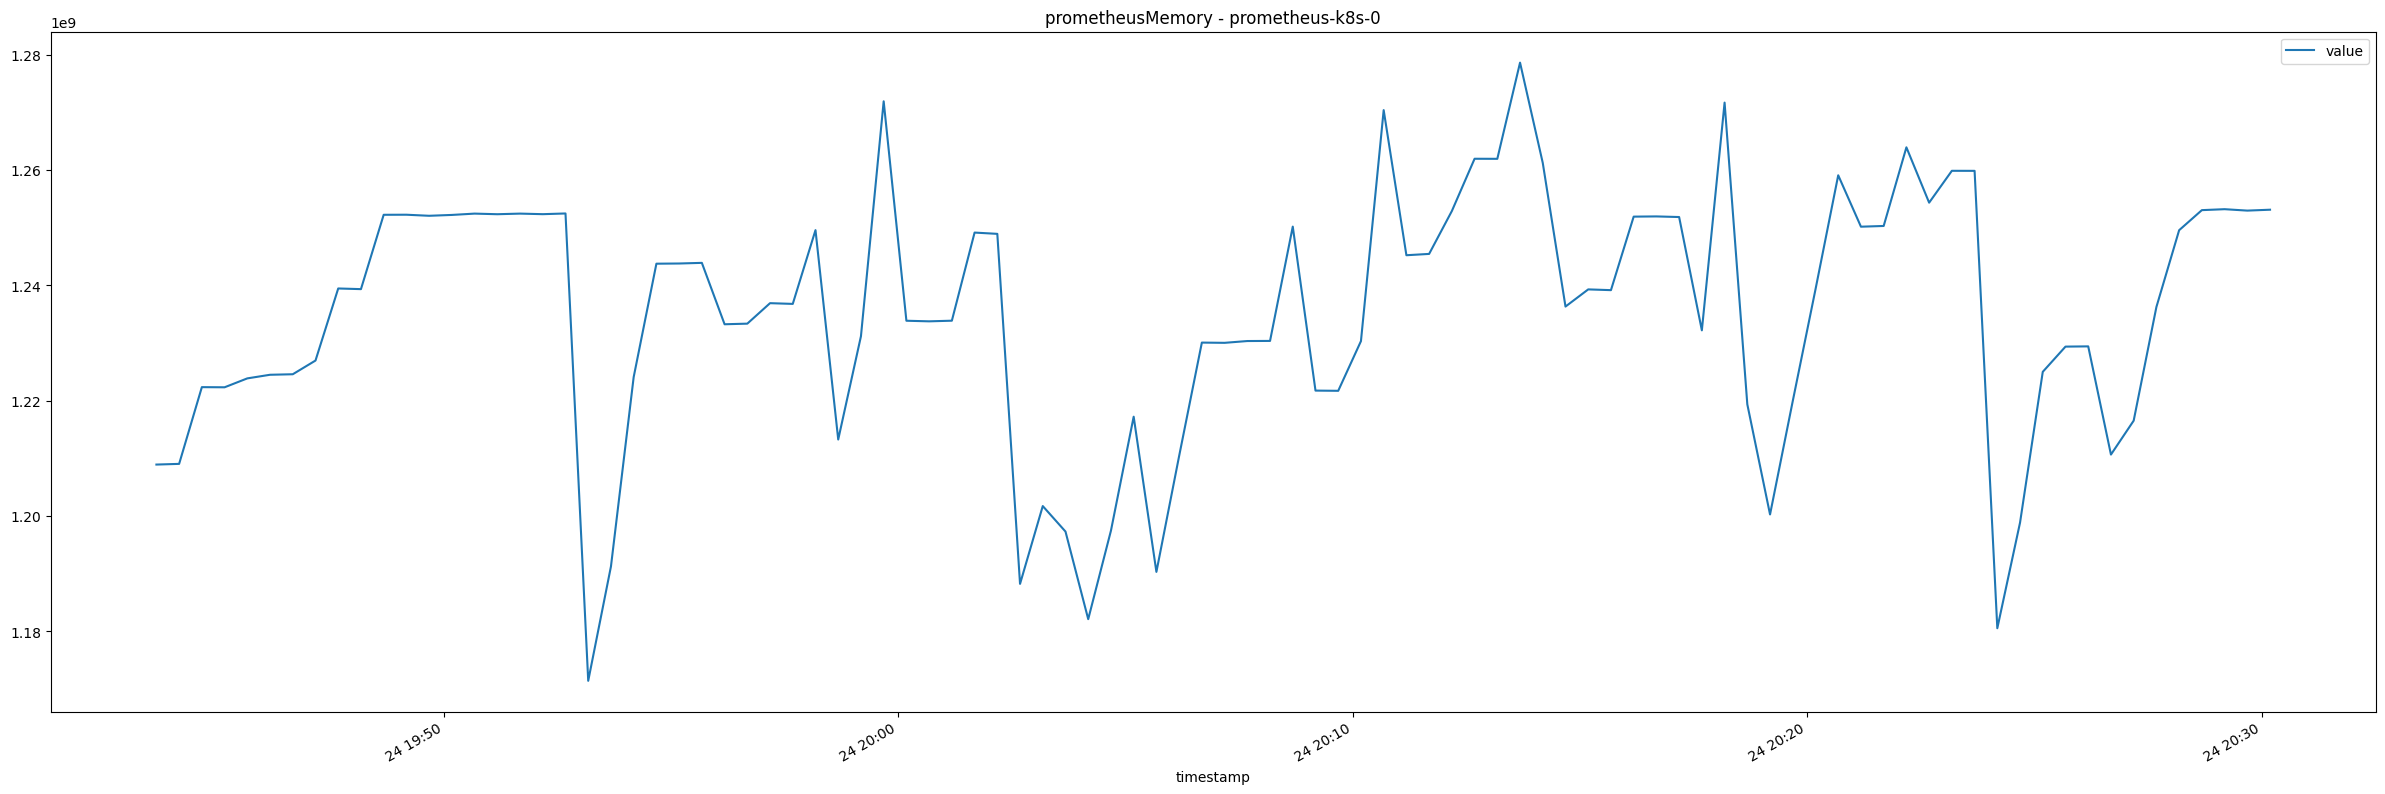

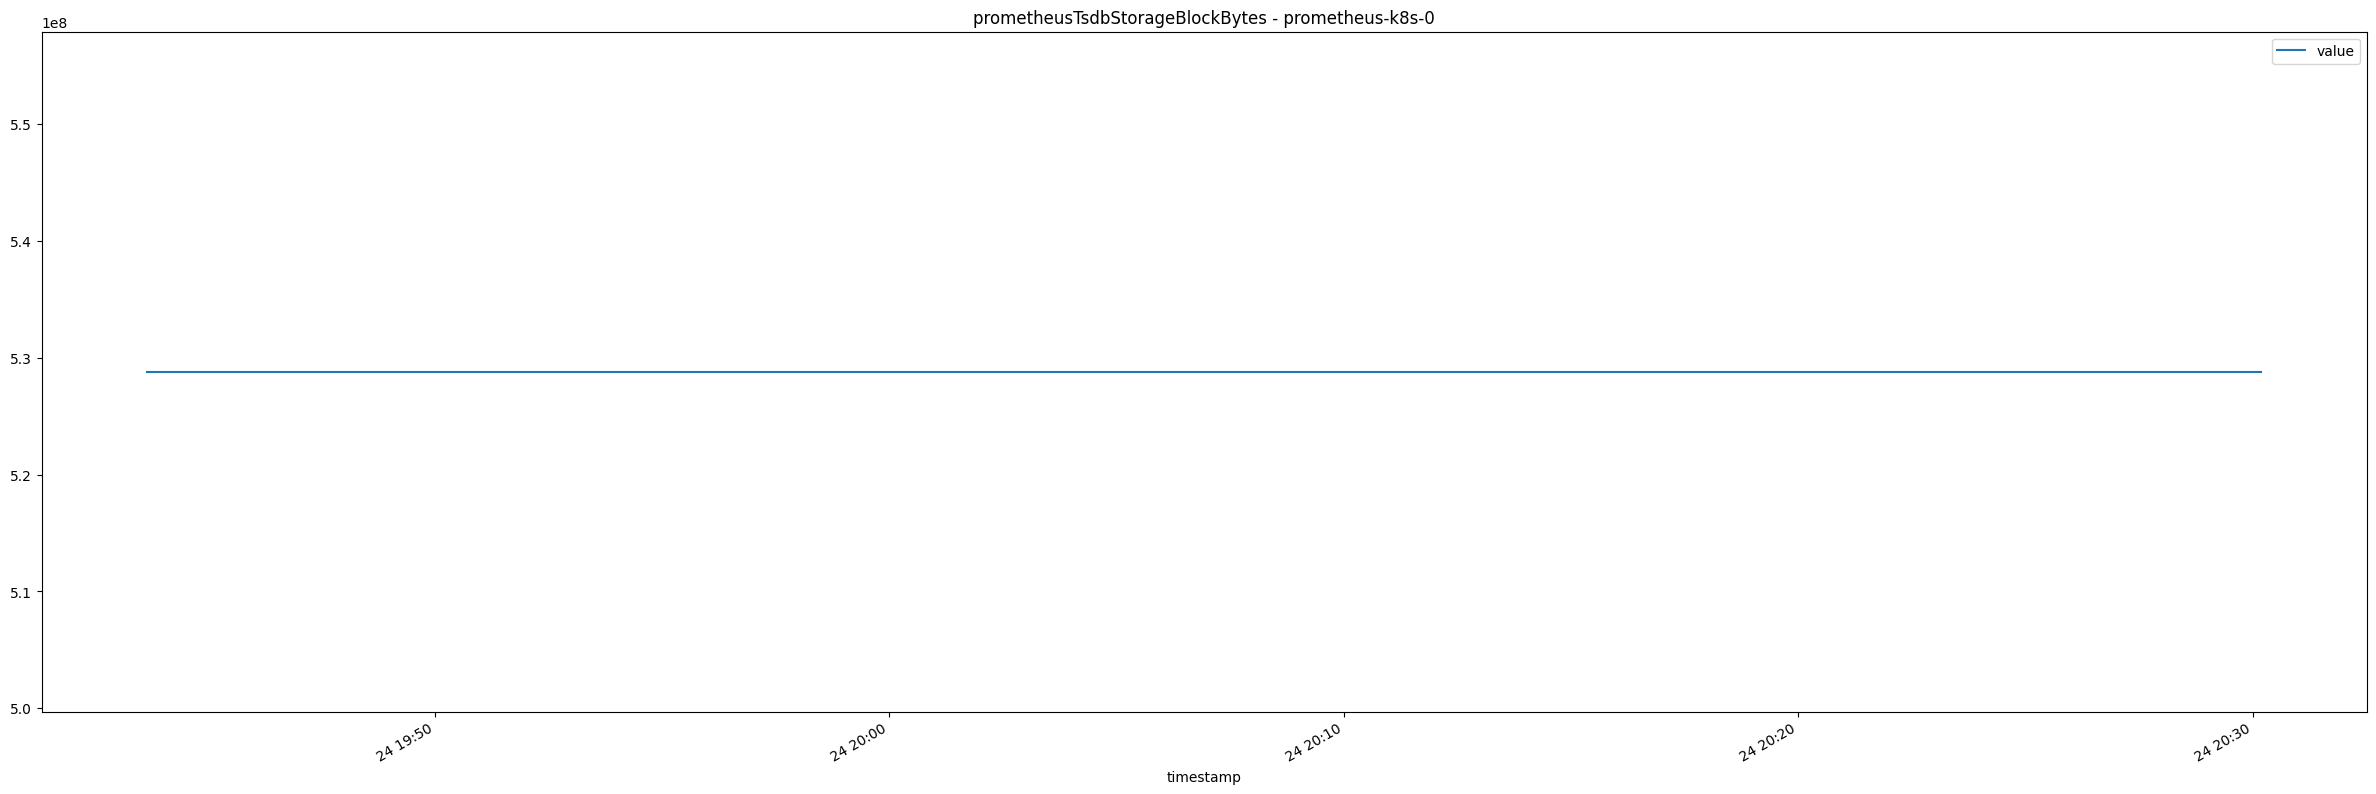

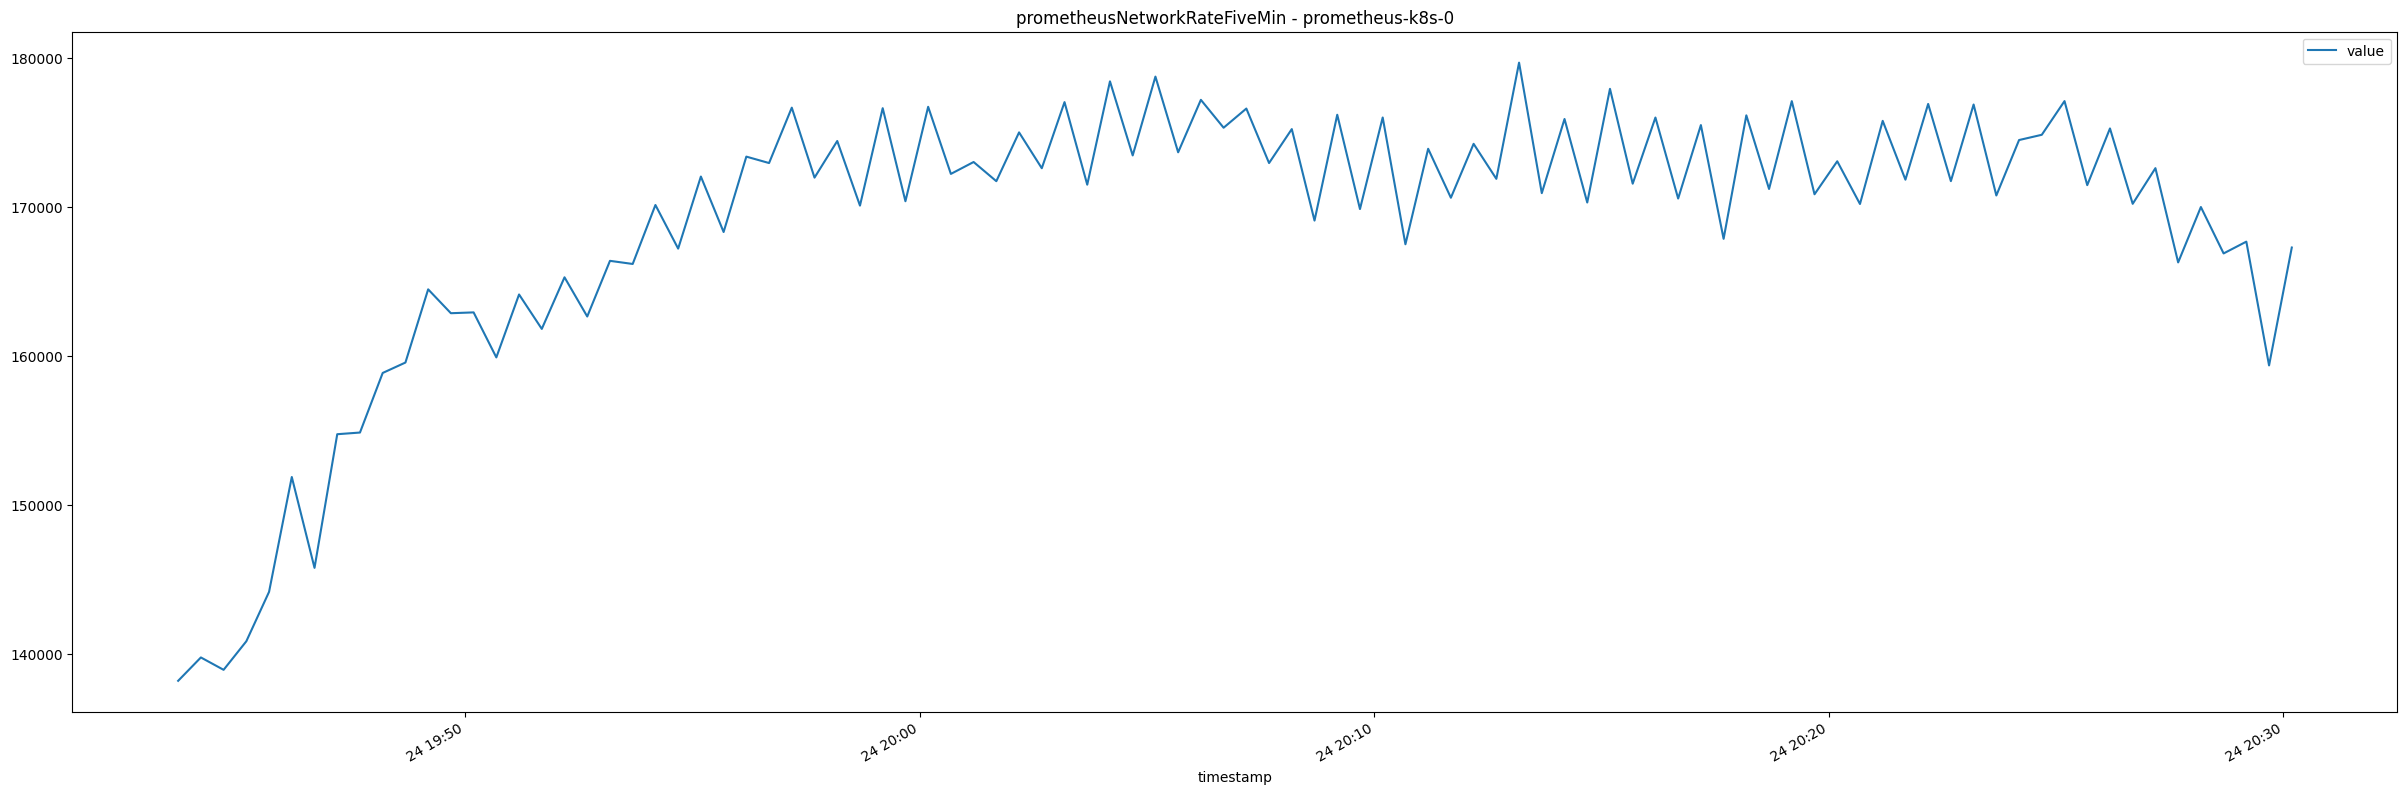

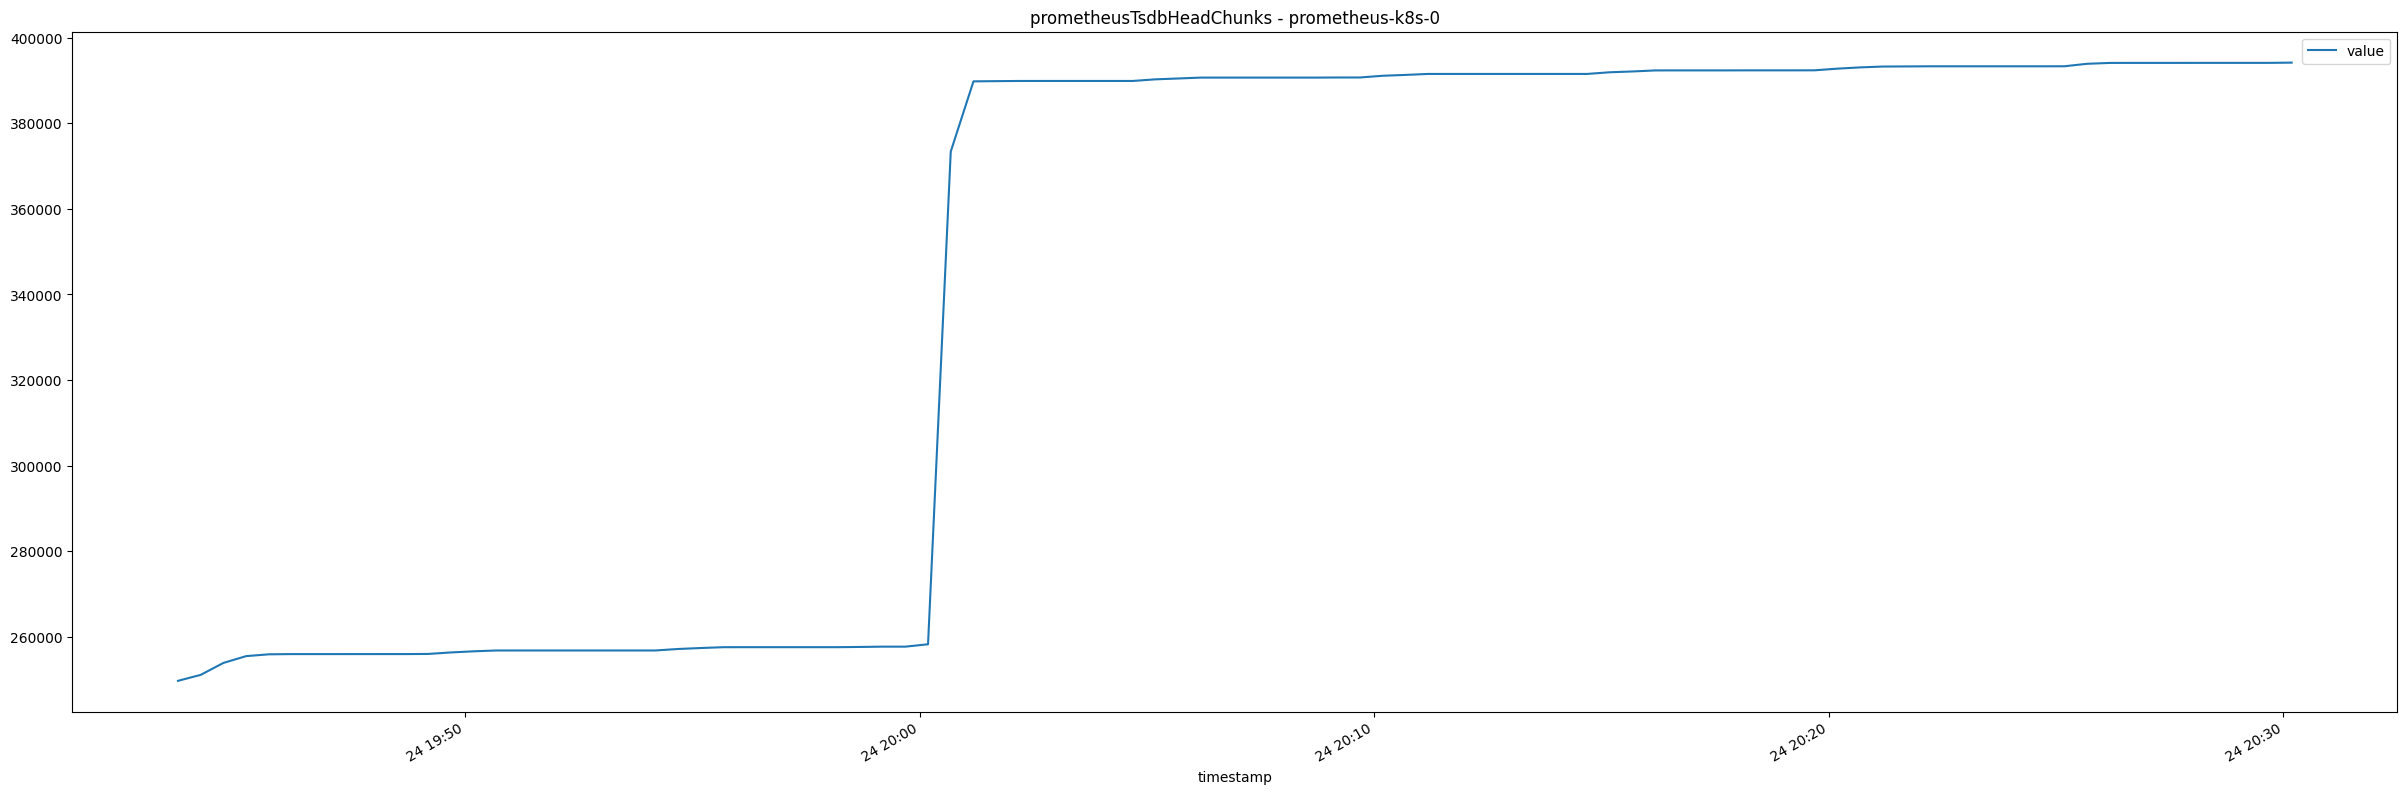

In [6]:
for metric_name, df in metric_dfs.items():
    print_metric_name(metric_name)
    metric_summary(metric_name, df)